In [1]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [99]:
plt.style.use('dark_background')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']
potential = 6600 #Per roof median potential kWh AC/yr https://insights.sustainability.google/places/ChIJOwV0Q_qxKIQR7NCkjDwfR-k/solar
dist = 1000 #Catchment area in sq m.

In [26]:
gdf_est = aqiGDL.gdf_from_db('estaciones_gdl','Estaciones')
#gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')

In [75]:
data = []
areas = {}
edges_data = []
for i in range(len(gdf_est)):
    x = gdf_est.at[i,'x']
    y = gdf_est.at[i,'y']
    est = gdf_est.at[i,'Name']
    point = (y, x)
    tags = {'building': True}
    gdf = ox.geometries_from_point(point, tags, dist=dist)
    gdf['Estacion'] = est
    # calculate the area in projected units (meters) of each building footprint
    gdf = ox.project_gdf(gdf)
    gdf['area'] = gdf.area
    gdf['kWh_year'] = gdf['area'] * potential
    data.append(gdf)
    areas[est] = gdf['area'].sum()
    G = ox.graph_from_point(point,dist=dist)
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['Estacion'] = est
    edges = ox.project_gdf(edges)
    edges_data.append(edges)
    G = None
    edges = None

/Users/natera/miniconda3/envs/ox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
df = pd.DataFrame(areas, index = ['area']).T
df['kWh_year'] = df['area'] * potential
gdf_est_ = ox.project_gdf(gdf_est)
gdf_est_ = gdf_est_.merge(df, right_index=True, left_on = 'Name')

/Users/natera/miniconda3/envs/ox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
gdf_ = pd.concat(data, ignore_index=True)
edges = pd.concat(edges_data, ignore_index=True)

(658848.8096066542, 679124.3225759314, 2274207.8519104533, 2296335.916540988)

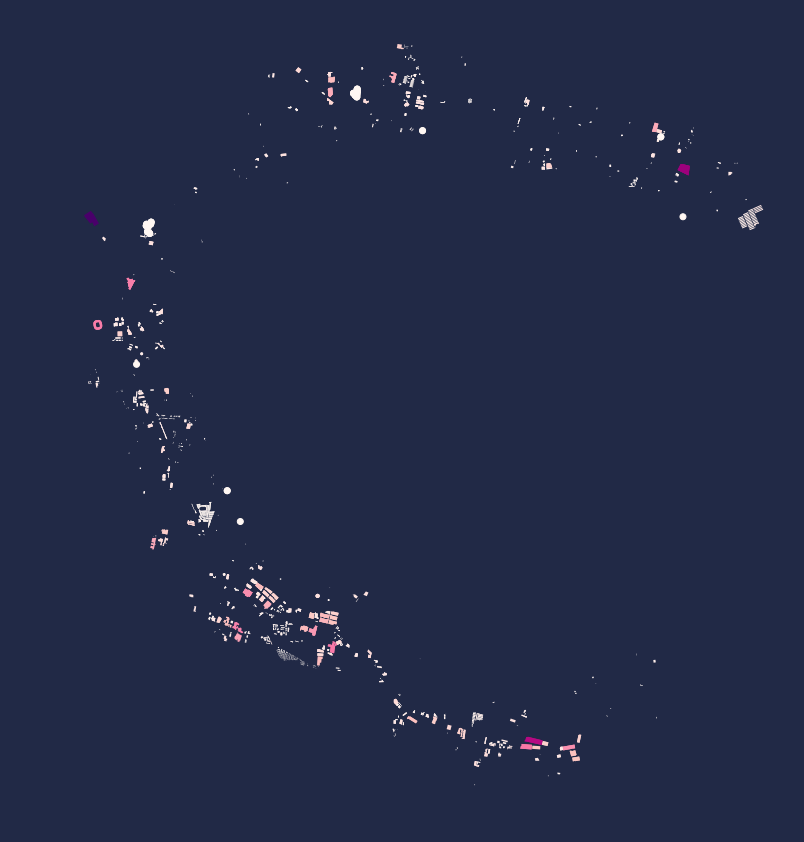

In [31]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
gdf_.plot(ax=ax, column='area')
#gdf_est_.plot(ax=ax, column = 'kWh_year', cmap='YlOrRd', markersize=gdf_est_['kWh_year']/1000000, alpha=0.65, legend=True)
ax.axis('off')

In [35]:
gdf_.head(1)

,unique_id,osmid,element_type,geometry,nodes,building,addr:city,addr:street,name,office,...,fuel:octane_91,bus,ref,ele,addr:country,craft,designation,dispensing,official_name,name:es
0,way/155165037,155165037,way,"POLYGON ((666559.024 2278988.474, 666566.704 2...","[4868672036, 1742199653, 1742199691, 174219968...",retail,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/natera/miniconda3/envs/ox/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


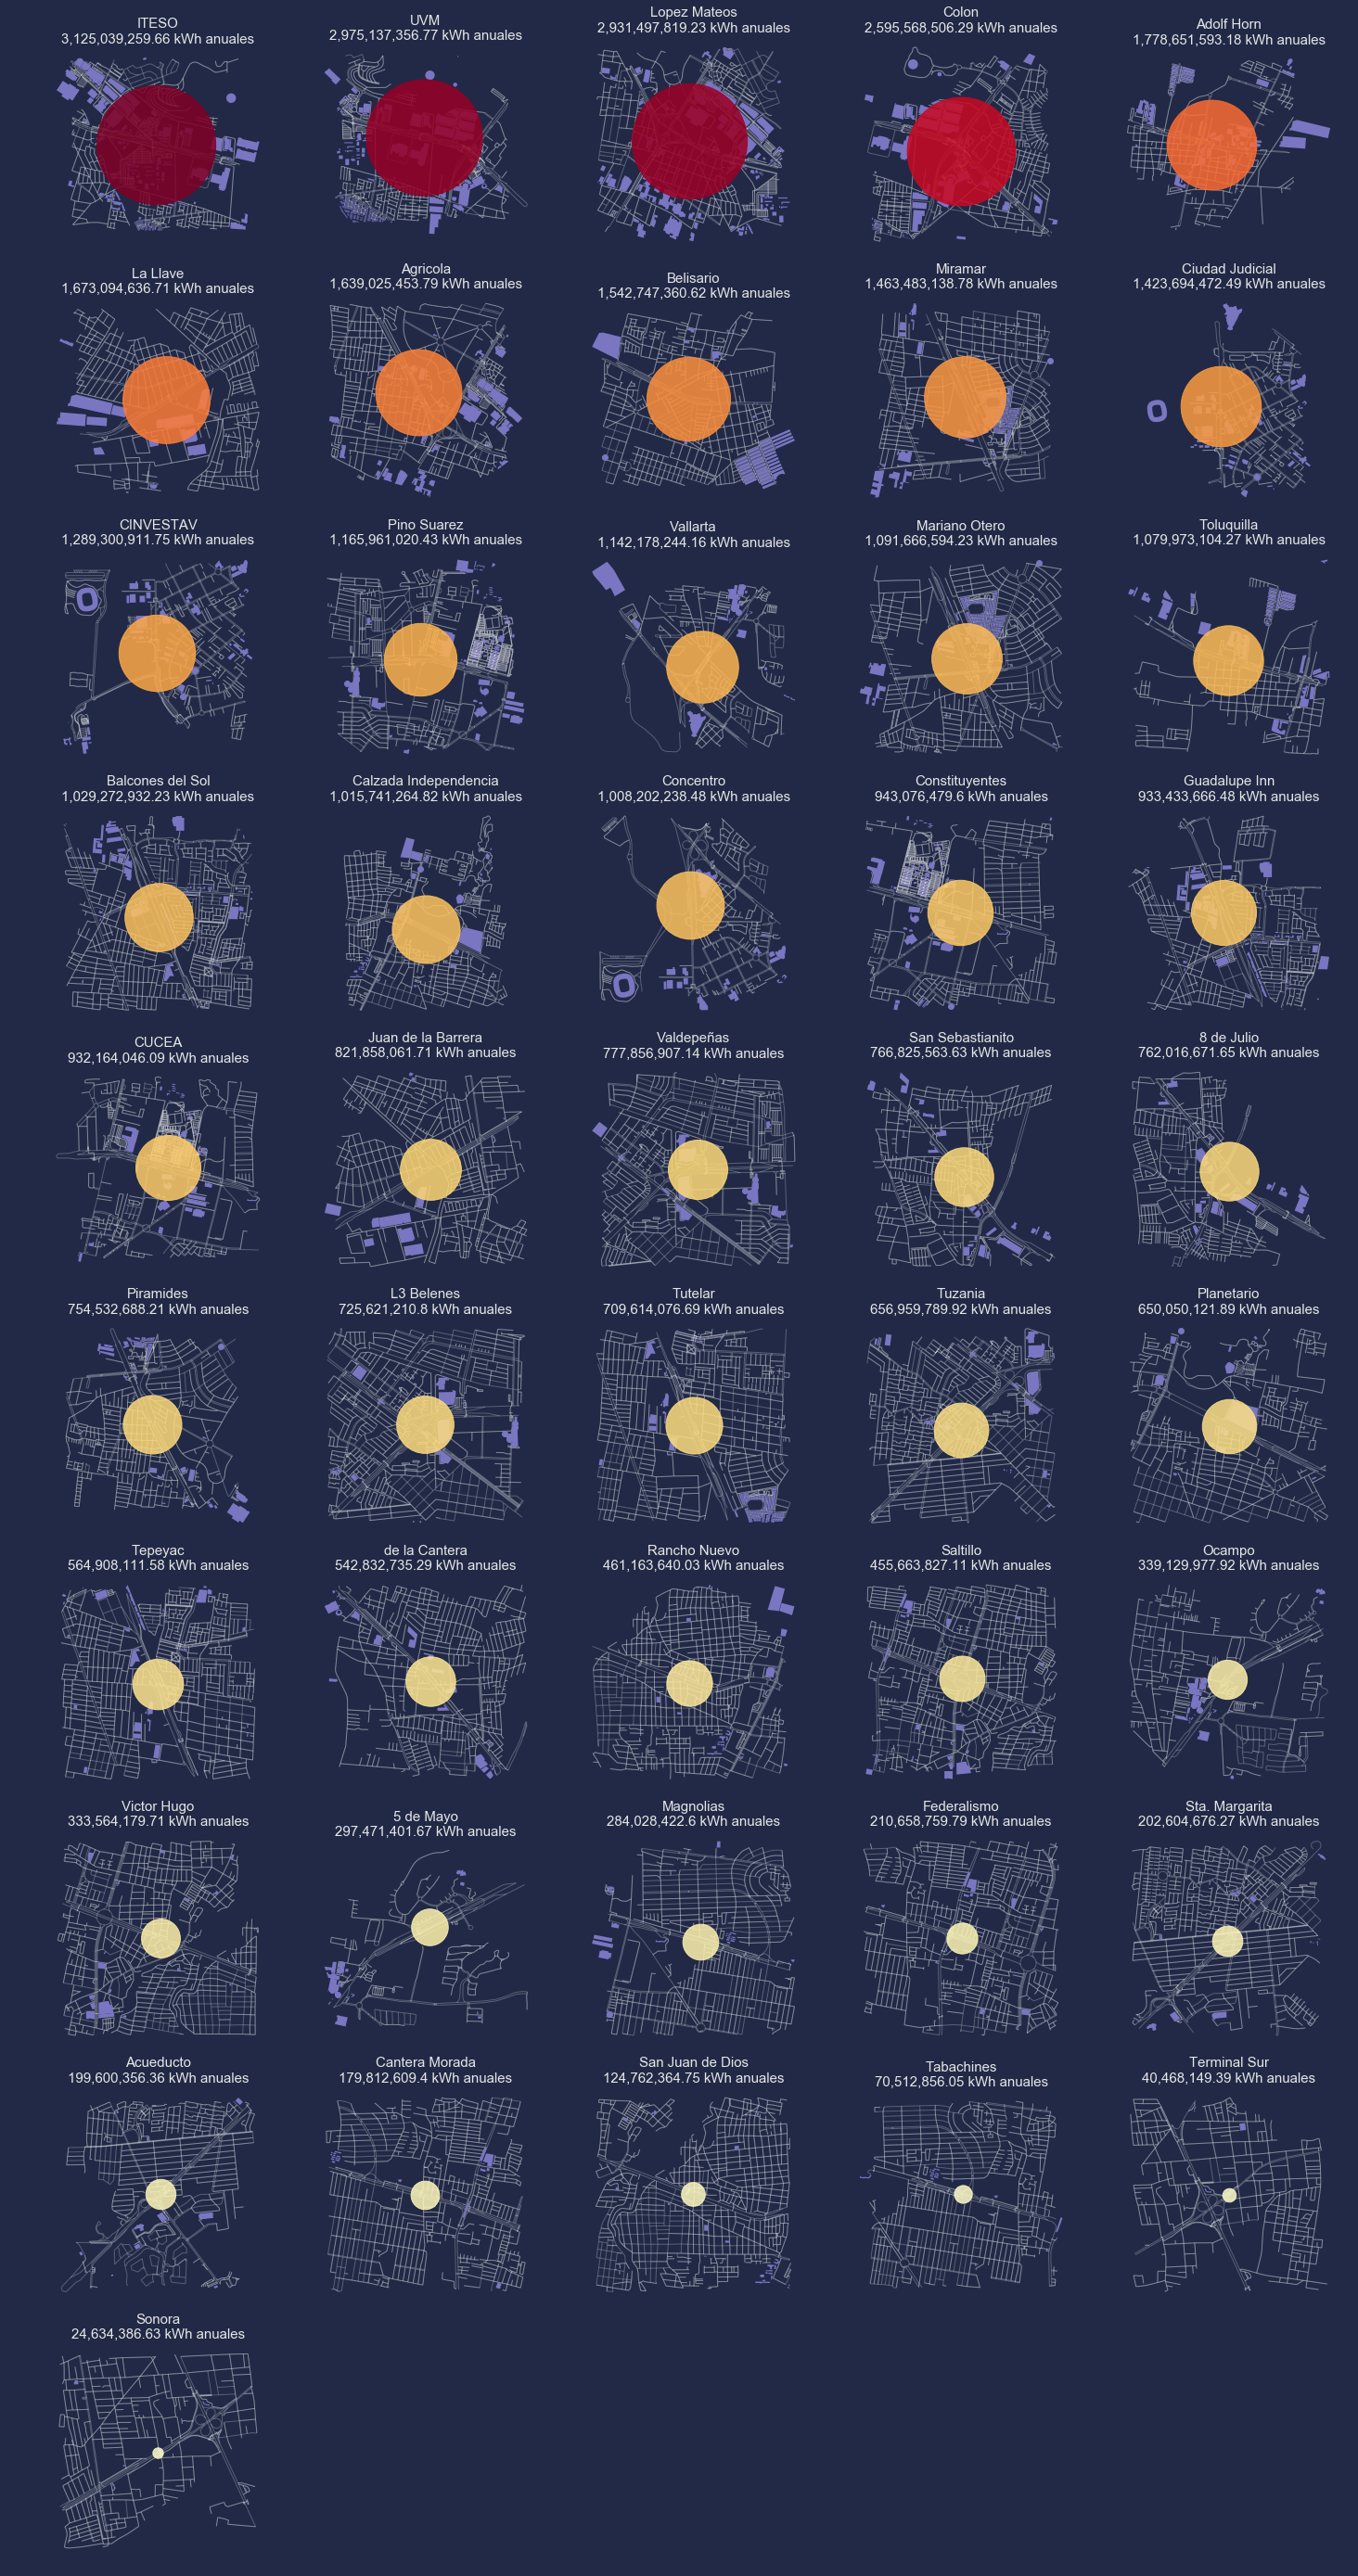

In [169]:
fig, axes = plt.subplots(10,5,figsize = (25,50))
for i, ax in zip(gdf_est_.index.tolist(), axes.flatten()):
    est = gdf_est.at[i,'Name']
    gdf_[gdf_['Estacion'] == est].plot(ax=ax, color='#7A76C2', zorder=2)
    edges[edges['Estacion'] == est].plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
    gdf_est_[gdf_est_['Name'] == est].plot(ax=ax, column ='kWh_year', cmap='YlOrRd', markersize=gdf_est_[gdf_est_['Name'] == est]['kWh_year']/190000, alpha=0.85, zorder=3, vmin=gdf_est_['kWh_year'].min(), vmax=gdf_est_['kWh_year'].max())
    ax.set_title('{}\n{:,} kWh anuales'.format(est.split(' ',maxsplit=1)[1], round(gdf_est_[gdf_est_['Name'] == est]['kWh_year'].values[0],2)), fontsize=15)
    ax.axis('off')
for ax in axes.flatten()[46:]:
    ax.set_visible(False)
plt.savefig('../output/figures/potencial_solar/PotencialEstaciones_Mapa.png',dpi=300)

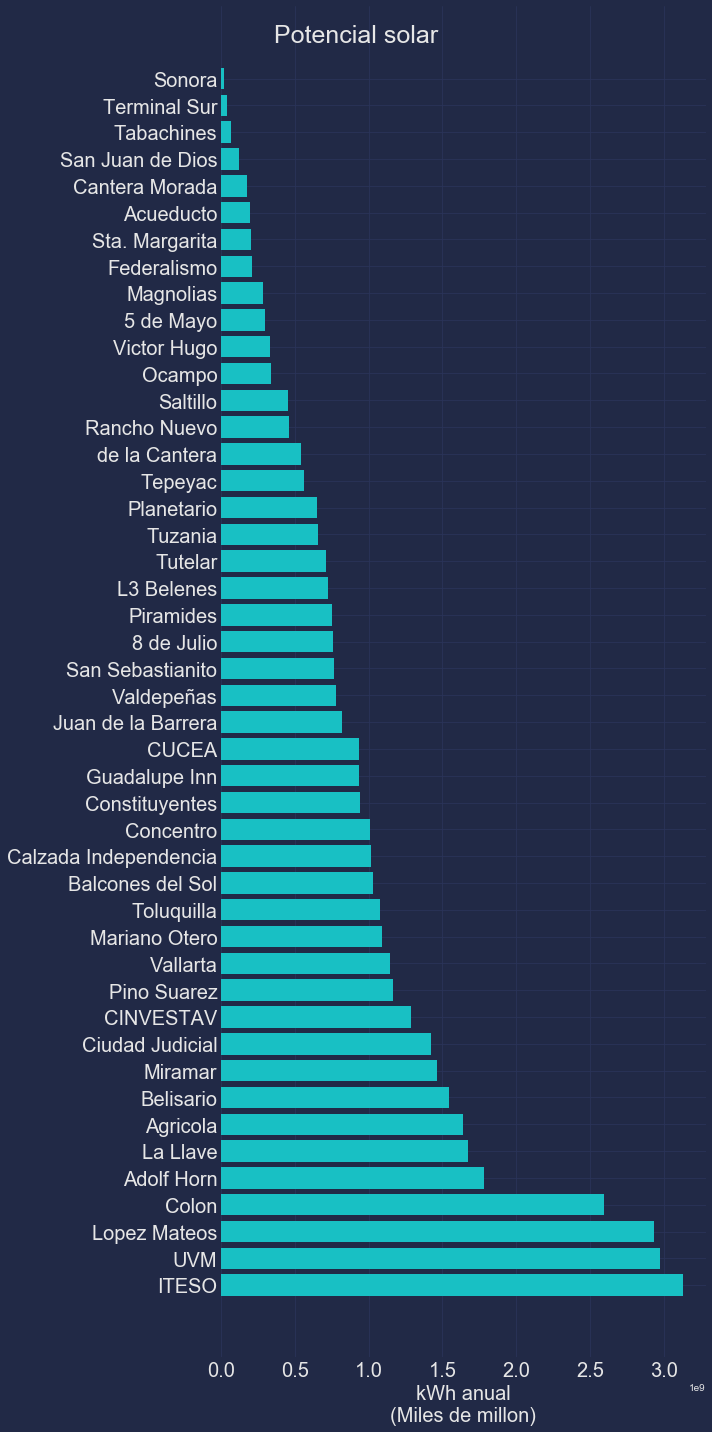

In [164]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(10,20))
ax.barh(gdf_est_['Name'].apply(lambda x: x.split(' ',maxsplit=1)[1]), gdf_est_['kWh_year'])
ax.set_xlabel('kWh anual\n(Miles de millon)',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Potencial solar',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/potencial_solar/PotencialEstaciones.png',dpi=300)